[*********************100%***********************]  1 of 1 completed
Down trend
Date:150 Short Sell at the price 334.42999267578125
Date:277 Stop Loss Sell at the price 351.260009765625
Down trend
Date:480 Short Sell at the price 376.1400146484375
Date:500 Stop Loss Sell at the price 396.82000732421875
Down trend
Date:566 Short Sell at the price 403.5
Date:652 Stop Loss Sell at the price 423.9200134277344
Down trend
Date:697 Short Sell at the price 410.4700012207031
Date:737 Stop Loss Sell at the price 431.3500061035156
Down trend
Date:1071 Short Sell at the price 460.5799865722656
Date:1296 Stop Loss Sell at the price 484.5400085449219
Down trend
Date:1652 Short Sell at the price 629.7999877929688
Date:1666 Stop Loss Sell at the price 662.489990234375
Down trend
Date:1840 Short Sell at the price 737.6500244140625
Date:1847 Stop Loss Sell at the price 774.6099853515625
Down trend
Date:1978 Short Sell at the price 876.989990234375
Date:1979 Stop Loss Sell at the price 921.8499755859375


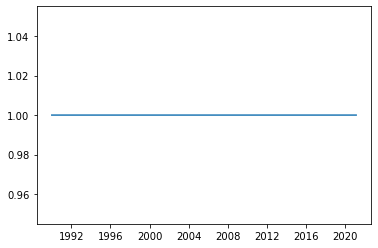

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf

start = '1990-01-01'
end = dt.datetime.now()
stock_code = '^GSPC'
df = yf.download(stock_code, start, end, interval='1d')
# print(df.head(65))

# 何日間で最大最小の値を保持
shortTerm = 20
longTerm = 60

# 損切り率と利確の日数
stopLoss = 0.95
rikaku_day = 80

# judge U trend or Down trend by DC
buy_position = False # 1 means entered and 0 means not already entered
sell_position = False

# 買った（売った）後に経過した日数、損切りラインを保持
buy_dates = 0
sell_dates = 0
buy_stopLine = 0
sell_stopLine = 0
counter = 1
percentChange = []

# 資産、購入したときの資産
assets = [1]
sell_asset = 1

# chek the highest price in the past {term} times
df['Highest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).max()
# chek the highest price in the past {term} times
df['Lowest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).min()

# chek the highest price in the past {term} times
df['Highest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).max()
# chek the highest price in the past {term} times
df['Lowest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).min()

# df.iloc[:,1]
# df['Highest'+str(longTerm)][:65]
# df['Lowest'+str(longTerm)][:65]

"""
メインループ
基本戦略
過去longTerm間の調整済み終値の最高値をその日の調整済み終値が更新したら購入or空売り
損切り率は5%。80日後に利確する。
最終日にまだ保持していた場合捌く
"""
# for i in range(1, len(df)):
for i in range(1,len(df)):
        
    shortHighest = df['Highest'+str(shortTerm)][i-1]
    shortLowest = df['Lowest'+str(shortTerm)][i-1]
    longHighest = df['Highest'+str(longTerm)][i-1]
    longLowest = df['Lowest'+str(longTerm)][i-1] 
    # high_price = df['High'][i]
    # low_price = df['Low'][i]
    close = df['Adj Close'][i]
    
    if buy_position == False:
        assets.append(assets[i-1])
    else:
        assets.append(sell_asset*(close / sell_price))
        
    # avoid NaN data 
    # 売りトレンド
    if (np.isnan(longLowest)) == False:
        if (close < longLowest and sell_position == False):
            print('Down trend')
            sell_position = True
            sell_price = close
            sell_stopLine = close * stopLoss
            sell_asset = assets[i]
            print('Date:'+str(i),'Short Sell at the price {}'.format(sell_price))

    # 損切り
    if sell_position == True and close > (sell_price + sell_price*(1-stopLoss)):
        sell_position = False
        percent = (sell_price/close - 1) * 100
        percentChange.append(percent)
        sell_dates = 0
        print('Date:'+str(i),'Stop Loss Sell at the price {}'.format(close))

    # 利確
    if sell_dates == 80:
        sell_position = False
        percent = (sell_price/close - 1) * 100
        percentChange.append(percent)
        sell_dates = 0
        print('Date:'+str(i),'Secure Profit Sell at the price {}'.format(close))
        
    # 損切りラインの更新
    # if buy_position = 

    #  最終日にまだ持ってたら利確する
    if (counter == df['Adj Close'].count() - 1):
        if sell_position == True:
            sell_position = False
            percent = (sell_price/close - 1) * 100
            percentChange.append(percent)
            sell_dates = 0
            print('Date:'+str(i),'Last Day Sell at the price {}'.format(close))

    # 買ってからの日数を更新する
    if buy_position == True:
        buy_dates += 1
    counter += 1



print(percentChange)

# statistic
gains = 0
numGains = 0
losses = 0
numLosses = 0
total_return = 1

for i in percentChange:
    if i > 0:
        numGains += 1
        gains += i
    else:
        numLosses += 1
        losses += i
    total_return = total_return * ((i / 100) + 1)

total_return = round((total_return - 1)*100, 2)

if numGains > 0:
    average_gain = gains / numGains
    max_return = max(percentChange)
else:
    average_gain = 0
    max_return = 'unknown'
    
if numLosses > 0:
    average_loss = losses / numLosses
    max_loss = min(percentChange)
    risk_reward_retio = - average_gain / average_loss
else:
    average_loss = 0
    max_loss = 'unknown'
    risk_reward_retio = 'inf'
    
if numGains > 0 or numLosses > 0:
    batting_ratio = numGains / (numGains + numLosses)
else:
    batting_ratio = 0
    
print('The period is from {} up to {}'.format(df.index[0], df.index[-1]))
print('Trades: {}'.format(numGains+numLosses))
print('Total return: {}%'.format(total_return))
print('Average Gain: {}'.format(average_gain))
print('Average Loss: {}'.format(average_loss))
print('Max Return: {}'.format(max_return))
print('Max Loss: {}'.format(max_loss))
print('Gain/Loss Ratio: {}'.format(risk_reward_retio))
print('Batting Average: {}'.format(batting_ratio))

assets = np.array(assets)
print(assets)
print(assets.min())
print('{}%'.format((round((1-assets.min())*100,2))))
plt.plot(df.index,assets)
plt.show()